# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 8.1) Supervised Euclidean for LASTEN2
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
tf.keras.backend.clear_session()

store_path = 'experiments/8_1_euclidean'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/test'

#path_fixed = r'D:\Julian\data\LASTEN2\fix'
#path_train = r'D:\Julian\data\LASTEN2\train'
#path_validation = r'D:\Julian\data\LASTEN2\validation'
#path_test = r'D:\Julian\data\LASTEN2\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/100


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


84/84 [==============================] - 49s 578ms/step - loss: 1046.4774 - val_loss: 10918.7080
Epoch 2/100
84/84 [==============================] - 50s 591ms/step - loss: 428.3996 - val_loss: 1292.9630
Epoch 3/100
84/84 [==============================] - 49s 586ms/step - loss: 226.9274 - val_loss: 558.1604
Epoch 4/100
84/84 [==============================] - 49s 589ms/step - loss: 172.9062 - val_loss: 533.1637
Epoch 5/100
84/84 [==============================] - 50s 590ms/step - loss: 115.3071 - val_loss: 142.5794
Epoch 6/100
84/84 [==============================] - 50s 593ms/step - loss: 71.1081 - val_loss: 187.4314
Epoch 7/100
84/84 [==============================] - 50s 590ms/step - loss: 61.1909 - val_loss: 81.9022
Epoch 8/100
84/84 [==============================] - 49s 585ms/step - loss: 63.9441 - val_loss: 549.8427
Epoch 9/100
84/84 [==============================] - 49s 583ms/step - loss: 42.1091 - val_loss: 292.5929
Epoch 10/100


84/84 [==============================] - 48s 577ms/step - loss: 36.2976 - val_loss: 68.5427
Epoch 11/100
84/84 [==============================] - 49s 584ms/step - loss: 27.5079 - val_loss: 73.2423
Epoch 12/100
84/84 [==============================] - 49s 585ms/step - loss: 20.1257 - val_loss: 41.0911
Epoch 13/100
84/84 [==============================] - 49s 585ms/step - loss: 21.3459 - val_loss: 49.8178
Epoch 14/100
84/84 [==============================] - 49s 586ms/step - loss: 26.5006 - val_loss: 97.6189
Epoch 15/100
84/84 [==============================] - 49s 588ms/step - loss: 28.7615 - val_loss: 150.9309
Epoch 16/100
84/84 [==============================] - 49s 588ms/step - loss: 19.5791 - val_loss: 46.3205
Epoch 17/100
84/84 [==============================] - 49s 586ms/step - loss: 23.0117 - val_loss: 52.6739
Epoch 18/100
84/84 [==============================] - 49s 585ms/step - loss: 14.7899 - val_loss: 28.4646
Epoch 19/100
83/84 [============================>.] - ETA: 0s - los

84/84 [==============================] - 49s 584ms/step - loss: 13.2682 - val_loss: 39.5263
Epoch 20/100
84/84 [==============================] - 48s 577ms/step - loss: 10.7144 - val_loss: 13.1486
Epoch 21/100
84/84 [==============================] - 48s 577ms/step - loss: 11.4971 - val_loss: 40.5738
Epoch 22/100
84/84 [==============================] - 50s 591ms/step - loss: 10.2074 - val_loss: 31.0800
Epoch 23/100
84/84 [==============================] - 49s 589ms/step - loss: 12.5885 - val_loss: 74.2810
Epoch 24/100
84/84 [==============================] - 49s 586ms/step - loss: 9.0878 - val_loss: 36.9538
Epoch 25/100
84/84 [==============================] - 49s 586ms/step - loss: 13.0834 - val_loss: 37.5623
Epoch 26/100
84/84 [==============================] - 49s 587ms/step - loss: 19.4297 - val_loss: 41.7157
Epoch 27/100
84/84 [==============================] - 49s 586ms/step - loss: 20.8478 - val_loss: 66.5690
Epoch 28/100
84/84 [==============================] - ETA: 0s - loss:

84/84 [==============================] - 49s 584ms/step - loss: 15.7702 - val_loss: 38.6453
Epoch 29/100
84/84 [==============================] - 48s 576ms/step - loss: 8.3393 - val_loss: 20.0201
Epoch 30/100
84/84 [==============================] - 50s 591ms/step - loss: 8.4133 - val_loss: 20.5762
Epoch 31/100
84/84 [==============================] - 49s 585ms/step - loss: 14.5989 - val_loss: 53.7516
Epoch 32/100
84/84 [==============================] - 49s 586ms/step - loss: 9.1826 - val_loss: 38.6052
Epoch 33/100
84/84 [==============================] - 49s 587ms/step - loss: 17.1409 - val_loss: 89.8921
Epoch 34/100
84/84 [==============================] - 50s 590ms/step - loss: 18.0956 - val_loss: 60.9558
Epoch 35/100
84/84 [==============================] - 49s 588ms/step - loss: 33.5692 - val_loss: 190.6672
Epoch 36/100
84/84 [==============================] - 49s 587ms/step - loss: 10.5544 - val_loss: 35.7161
Epoch 37/100
84/84 [==============================] - ETA: 0s - loss: 

84/84 [==============================] - 49s 586ms/step - loss: 8.9945 - val_loss: 8.4788
Epoch 38/100
84/84 [==============================] - 48s 573ms/step - loss: 11.8898 - val_loss: 16.6845
Epoch 39/100
84/84 [==============================] - 48s 570ms/step - loss: 8.4527 - val_loss: 38.7140
Epoch 40/100
84/84 [==============================] - 48s 577ms/step - loss: 7.7133 - val_loss: 9.9340
Epoch 41/100
84/84 [==============================] - 48s 570ms/step - loss: 5.9171 - val_loss: 9.8127
Epoch 42/100
84/84 [==============================] - 48s 570ms/step - loss: 6.6881 - val_loss: 7.6311
Epoch 43/100
84/84 [==============================] - 48s 570ms/step - loss: 5.1117 - val_loss: 7.7331
Epoch 44/100
84/84 [==============================] - 48s 573ms/step - loss: 11.3606 - val_loss: 75.4807
Epoch 45/100
84/84 [==============================] - 48s 570ms/step - loss: 16.1987 - val_loss: 23.5513
Epoch 46/100
84/84 [==============================] - 48s 572ms/step - loss: 8.

84/84 [==============================] - 48s 577ms/step - loss: 4.7673 - val_loss: 16.3364
Epoch 48/100
84/84 [==============================] - 48s 575ms/step - loss: 4.1321 - val_loss: 10.0123
Epoch 49/100
84/84 [==============================] - 48s 573ms/step - loss: 4.0516 - val_loss: 12.6483
Epoch 50/100
84/84 [==============================] - 49s 580ms/step - loss: 5.6498 - val_loss: 9.0949
Epoch 51/100
84/84 [==============================] - 49s 581ms/step - loss: 4.3071 - val_loss: 12.2619
Epoch 52/100
84/84 [==============================] - 48s 576ms/step - loss: 6.1040 - val_loss: 13.0019
Epoch 53/100
84/84 [==============================] - 48s 577ms/step - loss: 6.6657 - val_loss: 19.7449
Epoch 54/100
84/84 [==============================] - 48s 577ms/step - loss: 9.9247 - val_loss: 20.7220
Epoch 55/100
84/84 [==============================] - 48s 577ms/step - loss: 11.2507 - val_loss: 392.0812
Epoch 56/100
83/84 [============================>.] - ETA: 0s - loss: 31.679

84/84 [==============================] - 48s 576ms/step - loss: 31.5776 - val_loss: 48.2366
Epoch 57/100
84/84 [==============================] - 48s 573ms/step - loss: 18.5834 - val_loss: 190.9550
Epoch 58/100
84/84 [==============================] - 50s 598ms/step - loss: 11.7070 - val_loss: 26.9070
Epoch 59/100
84/84 [==============================] - 49s 585ms/step - loss: 8.3464 - val_loss: 7.8967
Epoch 60/100
84/84 [==============================] - 48s 573ms/step - loss: 5.1948 - val_loss: 18.0528
Epoch 61/100
84/84 [==============================] - 50s 598ms/step - loss: 5.5819 - val_loss: 11.6467
Epoch 62/100
84/84 [==============================] - 48s 567ms/step - loss: 4.4324 - val_loss: 10.5508
Epoch 63/100
84/84 [==============================] - 48s 568ms/step - loss: 6.9121 - val_loss: 18.8459
Epoch 64/100
84/84 [==============================] - 48s 568ms/step - loss: 4.0463 - val_loss: 8.8337
Epoch 65/100
84/84 [==============================] - ETA: 0s - loss: 4.735

84/84 [==============================] - 48s 569ms/step - loss: 4.7359 - val_loss: 19.6941
Epoch 66/100
84/84 [==============================] - 48s 576ms/step - loss: 7.5874 - val_loss: 9.9303
Epoch 67/100
84/84 [==============================] - 51s 608ms/step - loss: 9.7565 - val_loss: 24.3501
Epoch 68/100
84/84 [==============================] - 51s 608ms/step - loss: 4.6561 - val_loss: 11.6257
Epoch 69/100
84/84 [==============================] - 52s 615ms/step - loss: 4.7264 - val_loss: 24.2337
Epoch 70/100
84/84 [==============================] - 50s 596ms/step - loss: 7.0695 - val_loss: 12.7389
Epoch 71/100
84/84 [==============================] - 48s 573ms/step - loss: 4.7347 - val_loss: 7.0573
Epoch 72/100
84/84 [==============================] - 49s 585ms/step - loss: 3.3783 - val_loss: 8.9241
Epoch 73/100
84/84 [==============================] - 48s 569ms/step - loss: 3.4067 - val_loss: 9.0278
Epoch 74/100
84/84 [==============================] - ETA: 0s - loss: 5.0670WARNI

84/84 [==============================] - 48s 570ms/step - loss: 5.0670 - val_loss: 13.8877
Epoch 75/100
84/84 [==============================] - 48s 568ms/step - loss: 4.6921 - val_loss: 10.5714
Epoch 76/100
84/84 [==============================] - 48s 567ms/step - loss: 3.4525 - val_loss: 15.0702
Epoch 77/100
84/84 [==============================] - 48s 569ms/step - loss: 5.2946 - val_loss: 19.1898
Epoch 78/100
84/84 [==============================] - 48s 568ms/step - loss: 5.6757 - val_loss: 18.7602
Epoch 79/100
84/84 [==============================] - 48s 568ms/step - loss: 5.5216 - val_loss: 9.6630
Epoch 80/100
84/84 [==============================] - 48s 574ms/step - loss: 4.4578 - val_loss: 18.9405
Epoch 81/100
84/84 [==============================] - 48s 570ms/step - loss: 3.5567 - val_loss: 10.7951
Epoch 82/100
84/84 [==============================] - 48s 570ms/step - loss: 7.0447 - val_loss: 8.2422
Epoch 83/100
84/84 [==============================] - 48s 569ms/step - loss: 6.

84/84 [==============================] - 48s 569ms/step - loss: 6.7598 - val_loss: 24.3185
Epoch 85/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7294 - val_loss: 13.8400
Epoch 86/100
84/84 [==============================] - 48s 568ms/step - loss: 3.7822 - val_loss: 16.9950
Epoch 87/100
84/84 [==============================] - 48s 570ms/step - loss: 4.9949 - val_loss: 17.5308
Epoch 88/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7823 - val_loss: 19.4007
Epoch 89/100
84/84 [==============================] - 48s 569ms/step - loss: 4.7100 - val_loss: 7.9975
Epoch 90/100
84/84 [==============================] - 48s 574ms/step - loss: 7.8637 - val_loss: 17.8354
Epoch 91/100
84/84 [==============================] - 49s 585ms/step - loss: 5.8352 - val_loss: 14.5949
Epoch 92/100
84/84 [==============================] - 48s 569ms/step - loss: 7.3806 - val_loss: 29.1353
Epoch 93/100
83/84 [============================>.] - ETA: 0s - loss: 10.3454W

84/84 [==============================] - 48s 570ms/step - loss: 10.3004 - val_loss: 15.1737
Epoch 94/100
84/84 [==============================] - 48s 569ms/step - loss: 4.4161 - val_loss: 8.6925
Epoch 95/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7366 - val_loss: 6.8038
Epoch 96/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7644 - val_loss: 9.7750
Epoch 97/100
84/84 [==============================] - 48s 568ms/step - loss: 2.8873 - val_loss: 6.5769
Epoch 98/100
84/84 [==============================] - 48s 569ms/step - loss: 2.8804 - val_loss: 5.3810
Epoch 99/100
84/84 [==============================] - 48s 568ms/step - loss: 2.0448 - val_loss: 4.6946
Epoch 100/100
84/84 [==============================] - 48s 575ms/step - loss: 2.2166 - val_loss: 9.9280


# Evaluation
Evaluate the trained network

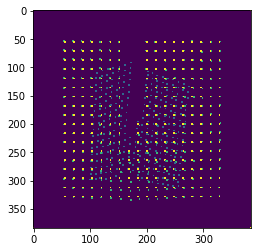

In [14]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 8.2) Supervised Euclidean for LASTEN2_10
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
tf.keras.backend.clear_session()

store_path = 'experiments/8_2_euclidean'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_10/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_10/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_10/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_10/test'

#path_fixed = r'D:\Julian\data\LASTEN2_10\fix'
#path_train = r'D:\Julian\data\LASTEN2_10\train'
#path_validation = r'D:\Julian\data\LASTEN2_10\validation'
#path_test = r'D:\Julian\data\LASTEN2_10\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/100


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


84/84 [==============================] - 49s 578ms/step - loss: 1046.4774 - val_loss: 10918.7080
Epoch 2/100
84/84 [==============================] - 50s 591ms/step - loss: 428.3996 - val_loss: 1292.9630
Epoch 3/100
84/84 [==============================] - 49s 586ms/step - loss: 226.9274 - val_loss: 558.1604
Epoch 4/100
84/84 [==============================] - 49s 589ms/step - loss: 172.9062 - val_loss: 533.1637
Epoch 5/100
84/84 [==============================] - 50s 590ms/step - loss: 115.3071 - val_loss: 142.5794
Epoch 6/100
84/84 [==============================] - 50s 593ms/step - loss: 71.1081 - val_loss: 187.4314
Epoch 7/100
84/84 [==============================] - 50s 590ms/step - loss: 61.1909 - val_loss: 81.9022
Epoch 8/100
84/84 [==============================] - 49s 585ms/step - loss: 63.9441 - val_loss: 549.8427
Epoch 9/100
84/84 [==============================] - 49s 583ms/step - loss: 42.1091 - val_loss: 292.5929
Epoch 10/100


84/84 [==============================] - 48s 577ms/step - loss: 36.2976 - val_loss: 68.5427
Epoch 11/100
84/84 [==============================] - 49s 584ms/step - loss: 27.5079 - val_loss: 73.2423
Epoch 12/100
84/84 [==============================] - 49s 585ms/step - loss: 20.1257 - val_loss: 41.0911
Epoch 13/100
84/84 [==============================] - 49s 585ms/step - loss: 21.3459 - val_loss: 49.8178
Epoch 14/100
84/84 [==============================] - 49s 586ms/step - loss: 26.5006 - val_loss: 97.6189
Epoch 15/100
84/84 [==============================] - 49s 588ms/step - loss: 28.7615 - val_loss: 150.9309
Epoch 16/100
84/84 [==============================] - 49s 588ms/step - loss: 19.5791 - val_loss: 46.3205
Epoch 17/100
84/84 [==============================] - 49s 586ms/step - loss: 23.0117 - val_loss: 52.6739
Epoch 18/100
84/84 [==============================] - 49s 585ms/step - loss: 14.7899 - val_loss: 28.4646
Epoch 19/100
83/84 [============================>.] - ETA: 0s - los

84/84 [==============================] - 49s 584ms/step - loss: 13.2682 - val_loss: 39.5263
Epoch 20/100
84/84 [==============================] - 48s 577ms/step - loss: 10.7144 - val_loss: 13.1486
Epoch 21/100
84/84 [==============================] - 48s 577ms/step - loss: 11.4971 - val_loss: 40.5738
Epoch 22/100
84/84 [==============================] - 50s 591ms/step - loss: 10.2074 - val_loss: 31.0800
Epoch 23/100
84/84 [==============================] - 49s 589ms/step - loss: 12.5885 - val_loss: 74.2810
Epoch 24/100
84/84 [==============================] - 49s 586ms/step - loss: 9.0878 - val_loss: 36.9538
Epoch 25/100
84/84 [==============================] - 49s 586ms/step - loss: 13.0834 - val_loss: 37.5623
Epoch 26/100
84/84 [==============================] - 49s 587ms/step - loss: 19.4297 - val_loss: 41.7157
Epoch 27/100
84/84 [==============================] - 49s 586ms/step - loss: 20.8478 - val_loss: 66.5690
Epoch 28/100
84/84 [==============================] - ETA: 0s - loss:

84/84 [==============================] - 49s 584ms/step - loss: 15.7702 - val_loss: 38.6453
Epoch 29/100
84/84 [==============================] - 48s 576ms/step - loss: 8.3393 - val_loss: 20.0201
Epoch 30/100
84/84 [==============================] - 50s 591ms/step - loss: 8.4133 - val_loss: 20.5762
Epoch 31/100
84/84 [==============================] - 49s 585ms/step - loss: 14.5989 - val_loss: 53.7516
Epoch 32/100
84/84 [==============================] - 49s 586ms/step - loss: 9.1826 - val_loss: 38.6052
Epoch 33/100
84/84 [==============================] - 49s 587ms/step - loss: 17.1409 - val_loss: 89.8921
Epoch 34/100
84/84 [==============================] - 50s 590ms/step - loss: 18.0956 - val_loss: 60.9558
Epoch 35/100
84/84 [==============================] - 49s 588ms/step - loss: 33.5692 - val_loss: 190.6672
Epoch 36/100
84/84 [==============================] - 49s 587ms/step - loss: 10.5544 - val_loss: 35.7161
Epoch 37/100
84/84 [==============================] - ETA: 0s - loss: 

84/84 [==============================] - 49s 586ms/step - loss: 8.9945 - val_loss: 8.4788
Epoch 38/100
84/84 [==============================] - 48s 573ms/step - loss: 11.8898 - val_loss: 16.6845
Epoch 39/100
84/84 [==============================] - 48s 570ms/step - loss: 8.4527 - val_loss: 38.7140
Epoch 40/100
84/84 [==============================] - 48s 577ms/step - loss: 7.7133 - val_loss: 9.9340
Epoch 41/100
84/84 [==============================] - 48s 570ms/step - loss: 5.9171 - val_loss: 9.8127
Epoch 42/100
84/84 [==============================] - 48s 570ms/step - loss: 6.6881 - val_loss: 7.6311
Epoch 43/100
84/84 [==============================] - 48s 570ms/step - loss: 5.1117 - val_loss: 7.7331
Epoch 44/100
84/84 [==============================] - 48s 573ms/step - loss: 11.3606 - val_loss: 75.4807
Epoch 45/100
84/84 [==============================] - 48s 570ms/step - loss: 16.1987 - val_loss: 23.5513
Epoch 46/100
84/84 [==============================] - 48s 572ms/step - loss: 8.

84/84 [==============================] - 48s 577ms/step - loss: 4.7673 - val_loss: 16.3364
Epoch 48/100
84/84 [==============================] - 48s 575ms/step - loss: 4.1321 - val_loss: 10.0123
Epoch 49/100
84/84 [==============================] - 48s 573ms/step - loss: 4.0516 - val_loss: 12.6483
Epoch 50/100
84/84 [==============================] - 49s 580ms/step - loss: 5.6498 - val_loss: 9.0949
Epoch 51/100
84/84 [==============================] - 49s 581ms/step - loss: 4.3071 - val_loss: 12.2619
Epoch 52/100
84/84 [==============================] - 48s 576ms/step - loss: 6.1040 - val_loss: 13.0019
Epoch 53/100
84/84 [==============================] - 48s 577ms/step - loss: 6.6657 - val_loss: 19.7449
Epoch 54/100
84/84 [==============================] - 48s 577ms/step - loss: 9.9247 - val_loss: 20.7220
Epoch 55/100
84/84 [==============================] - 48s 577ms/step - loss: 11.2507 - val_loss: 392.0812
Epoch 56/100
83/84 [============================>.] - ETA: 0s - loss: 31.679

84/84 [==============================] - 48s 576ms/step - loss: 31.5776 - val_loss: 48.2366
Epoch 57/100
84/84 [==============================] - 48s 573ms/step - loss: 18.5834 - val_loss: 190.9550
Epoch 58/100
84/84 [==============================] - 50s 598ms/step - loss: 11.7070 - val_loss: 26.9070
Epoch 59/100
84/84 [==============================] - 49s 585ms/step - loss: 8.3464 - val_loss: 7.8967
Epoch 60/100
84/84 [==============================] - 48s 573ms/step - loss: 5.1948 - val_loss: 18.0528
Epoch 61/100
84/84 [==============================] - 50s 598ms/step - loss: 5.5819 - val_loss: 11.6467
Epoch 62/100
84/84 [==============================] - 48s 567ms/step - loss: 4.4324 - val_loss: 10.5508
Epoch 63/100
84/84 [==============================] - 48s 568ms/step - loss: 6.9121 - val_loss: 18.8459
Epoch 64/100
84/84 [==============================] - 48s 568ms/step - loss: 4.0463 - val_loss: 8.8337
Epoch 65/100
84/84 [==============================] - ETA: 0s - loss: 4.735

84/84 [==============================] - 48s 569ms/step - loss: 4.7359 - val_loss: 19.6941
Epoch 66/100
84/84 [==============================] - 48s 576ms/step - loss: 7.5874 - val_loss: 9.9303
Epoch 67/100
84/84 [==============================] - 51s 608ms/step - loss: 9.7565 - val_loss: 24.3501
Epoch 68/100
84/84 [==============================] - 51s 608ms/step - loss: 4.6561 - val_loss: 11.6257
Epoch 69/100
84/84 [==============================] - 52s 615ms/step - loss: 4.7264 - val_loss: 24.2337
Epoch 70/100
84/84 [==============================] - 50s 596ms/step - loss: 7.0695 - val_loss: 12.7389
Epoch 71/100
84/84 [==============================] - 48s 573ms/step - loss: 4.7347 - val_loss: 7.0573
Epoch 72/100
84/84 [==============================] - 49s 585ms/step - loss: 3.3783 - val_loss: 8.9241
Epoch 73/100
84/84 [==============================] - 48s 569ms/step - loss: 3.4067 - val_loss: 9.0278
Epoch 74/100
84/84 [==============================] - ETA: 0s - loss: 5.0670WARNI

84/84 [==============================] - 48s 570ms/step - loss: 5.0670 - val_loss: 13.8877
Epoch 75/100
84/84 [==============================] - 48s 568ms/step - loss: 4.6921 - val_loss: 10.5714
Epoch 76/100
84/84 [==============================] - 48s 567ms/step - loss: 3.4525 - val_loss: 15.0702
Epoch 77/100
84/84 [==============================] - 48s 569ms/step - loss: 5.2946 - val_loss: 19.1898
Epoch 78/100
84/84 [==============================] - 48s 568ms/step - loss: 5.6757 - val_loss: 18.7602
Epoch 79/100
84/84 [==============================] - 48s 568ms/step - loss: 5.5216 - val_loss: 9.6630
Epoch 80/100
84/84 [==============================] - 48s 574ms/step - loss: 4.4578 - val_loss: 18.9405
Epoch 81/100
84/84 [==============================] - 48s 570ms/step - loss: 3.5567 - val_loss: 10.7951
Epoch 82/100
84/84 [==============================] - 48s 570ms/step - loss: 7.0447 - val_loss: 8.2422
Epoch 83/100
84/84 [==============================] - 48s 569ms/step - loss: 6.

84/84 [==============================] - 48s 569ms/step - loss: 6.7598 - val_loss: 24.3185
Epoch 85/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7294 - val_loss: 13.8400
Epoch 86/100
84/84 [==============================] - 48s 568ms/step - loss: 3.7822 - val_loss: 16.9950
Epoch 87/100
84/84 [==============================] - 48s 570ms/step - loss: 4.9949 - val_loss: 17.5308
Epoch 88/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7823 - val_loss: 19.4007
Epoch 89/100
84/84 [==============================] - 48s 569ms/step - loss: 4.7100 - val_loss: 7.9975
Epoch 90/100
84/84 [==============================] - 48s 574ms/step - loss: 7.8637 - val_loss: 17.8354
Epoch 91/100
84/84 [==============================] - 49s 585ms/step - loss: 5.8352 - val_loss: 14.5949
Epoch 92/100
84/84 [==============================] - 48s 569ms/step - loss: 7.3806 - val_loss: 29.1353
Epoch 93/100
83/84 [============================>.] - ETA: 0s - loss: 10.3454W

84/84 [==============================] - 48s 570ms/step - loss: 10.3004 - val_loss: 15.1737
Epoch 94/100
84/84 [==============================] - 48s 569ms/step - loss: 4.4161 - val_loss: 8.6925
Epoch 95/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7366 - val_loss: 6.8038
Epoch 96/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7644 - val_loss: 9.7750
Epoch 97/100
84/84 [==============================] - 48s 568ms/step - loss: 2.8873 - val_loss: 6.5769
Epoch 98/100
84/84 [==============================] - 48s 569ms/step - loss: 2.8804 - val_loss: 5.3810
Epoch 99/100
84/84 [==============================] - 48s 568ms/step - loss: 2.0448 - val_loss: 4.6946
Epoch 100/100
84/84 [==============================] - 48s 575ms/step - loss: 2.2166 - val_loss: 9.9280


# Evaluation
Evaluate the trained network

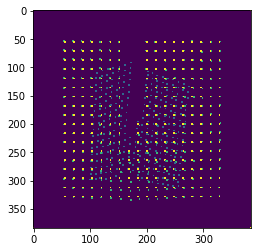

In [14]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 8.3) Supervised Euclidean for LASTEN2_25
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
tf.keras.backend.clear_session()

store_path = 'experiments/8_3_euclidean'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/test'

#path_fixed = r'D:\Julian\data\LASTEN2_25\fix'
#path_train = r'D:\Julian\data\LASTEN2_25\train'
#path_validation = r'D:\Julian\data\LASTEN2_25\validation'
#path_test = r'D:\Julian\data\LASTEN2_25\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/100


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


84/84 [==============================] - 49s 578ms/step - loss: 1046.4774 - val_loss: 10918.7080
Epoch 2/100
84/84 [==============================] - 50s 591ms/step - loss: 428.3996 - val_loss: 1292.9630
Epoch 3/100
84/84 [==============================] - 49s 586ms/step - loss: 226.9274 - val_loss: 558.1604
Epoch 4/100
84/84 [==============================] - 49s 589ms/step - loss: 172.9062 - val_loss: 533.1637
Epoch 5/100
84/84 [==============================] - 50s 590ms/step - loss: 115.3071 - val_loss: 142.5794
Epoch 6/100
84/84 [==============================] - 50s 593ms/step - loss: 71.1081 - val_loss: 187.4314
Epoch 7/100
84/84 [==============================] - 50s 590ms/step - loss: 61.1909 - val_loss: 81.9022
Epoch 8/100
84/84 [==============================] - 49s 585ms/step - loss: 63.9441 - val_loss: 549.8427
Epoch 9/100
84/84 [==============================] - 49s 583ms/step - loss: 42.1091 - val_loss: 292.5929
Epoch 10/100


84/84 [==============================] - 48s 577ms/step - loss: 36.2976 - val_loss: 68.5427
Epoch 11/100
84/84 [==============================] - 49s 584ms/step - loss: 27.5079 - val_loss: 73.2423
Epoch 12/100
84/84 [==============================] - 49s 585ms/step - loss: 20.1257 - val_loss: 41.0911
Epoch 13/100
84/84 [==============================] - 49s 585ms/step - loss: 21.3459 - val_loss: 49.8178
Epoch 14/100
84/84 [==============================] - 49s 586ms/step - loss: 26.5006 - val_loss: 97.6189
Epoch 15/100
84/84 [==============================] - 49s 588ms/step - loss: 28.7615 - val_loss: 150.9309
Epoch 16/100
84/84 [==============================] - 49s 588ms/step - loss: 19.5791 - val_loss: 46.3205
Epoch 17/100
84/84 [==============================] - 49s 586ms/step - loss: 23.0117 - val_loss: 52.6739
Epoch 18/100
84/84 [==============================] - 49s 585ms/step - loss: 14.7899 - val_loss: 28.4646
Epoch 19/100
83/84 [============================>.] - ETA: 0s - los

84/84 [==============================] - 49s 584ms/step - loss: 13.2682 - val_loss: 39.5263
Epoch 20/100
84/84 [==============================] - 48s 577ms/step - loss: 10.7144 - val_loss: 13.1486
Epoch 21/100
84/84 [==============================] - 48s 577ms/step - loss: 11.4971 - val_loss: 40.5738
Epoch 22/100
84/84 [==============================] - 50s 591ms/step - loss: 10.2074 - val_loss: 31.0800
Epoch 23/100
84/84 [==============================] - 49s 589ms/step - loss: 12.5885 - val_loss: 74.2810
Epoch 24/100
84/84 [==============================] - 49s 586ms/step - loss: 9.0878 - val_loss: 36.9538
Epoch 25/100
84/84 [==============================] - 49s 586ms/step - loss: 13.0834 - val_loss: 37.5623
Epoch 26/100
84/84 [==============================] - 49s 587ms/step - loss: 19.4297 - val_loss: 41.7157
Epoch 27/100
84/84 [==============================] - 49s 586ms/step - loss: 20.8478 - val_loss: 66.5690
Epoch 28/100
84/84 [==============================] - ETA: 0s - loss:

84/84 [==============================] - 49s 584ms/step - loss: 15.7702 - val_loss: 38.6453
Epoch 29/100
84/84 [==============================] - 48s 576ms/step - loss: 8.3393 - val_loss: 20.0201
Epoch 30/100
84/84 [==============================] - 50s 591ms/step - loss: 8.4133 - val_loss: 20.5762
Epoch 31/100
84/84 [==============================] - 49s 585ms/step - loss: 14.5989 - val_loss: 53.7516
Epoch 32/100
84/84 [==============================] - 49s 586ms/step - loss: 9.1826 - val_loss: 38.6052
Epoch 33/100
84/84 [==============================] - 49s 587ms/step - loss: 17.1409 - val_loss: 89.8921
Epoch 34/100
84/84 [==============================] - 50s 590ms/step - loss: 18.0956 - val_loss: 60.9558
Epoch 35/100
84/84 [==============================] - 49s 588ms/step - loss: 33.5692 - val_loss: 190.6672
Epoch 36/100
84/84 [==============================] - 49s 587ms/step - loss: 10.5544 - val_loss: 35.7161
Epoch 37/100
84/84 [==============================] - ETA: 0s - loss: 

84/84 [==============================] - 49s 586ms/step - loss: 8.9945 - val_loss: 8.4788
Epoch 38/100
84/84 [==============================] - 48s 573ms/step - loss: 11.8898 - val_loss: 16.6845
Epoch 39/100
84/84 [==============================] - 48s 570ms/step - loss: 8.4527 - val_loss: 38.7140
Epoch 40/100
84/84 [==============================] - 48s 577ms/step - loss: 7.7133 - val_loss: 9.9340
Epoch 41/100
84/84 [==============================] - 48s 570ms/step - loss: 5.9171 - val_loss: 9.8127
Epoch 42/100
84/84 [==============================] - 48s 570ms/step - loss: 6.6881 - val_loss: 7.6311
Epoch 43/100
84/84 [==============================] - 48s 570ms/step - loss: 5.1117 - val_loss: 7.7331
Epoch 44/100
84/84 [==============================] - 48s 573ms/step - loss: 11.3606 - val_loss: 75.4807
Epoch 45/100
84/84 [==============================] - 48s 570ms/step - loss: 16.1987 - val_loss: 23.5513
Epoch 46/100
84/84 [==============================] - 48s 572ms/step - loss: 8.

84/84 [==============================] - 48s 577ms/step - loss: 4.7673 - val_loss: 16.3364
Epoch 48/100
84/84 [==============================] - 48s 575ms/step - loss: 4.1321 - val_loss: 10.0123
Epoch 49/100
84/84 [==============================] - 48s 573ms/step - loss: 4.0516 - val_loss: 12.6483
Epoch 50/100
84/84 [==============================] - 49s 580ms/step - loss: 5.6498 - val_loss: 9.0949
Epoch 51/100
84/84 [==============================] - 49s 581ms/step - loss: 4.3071 - val_loss: 12.2619
Epoch 52/100
84/84 [==============================] - 48s 576ms/step - loss: 6.1040 - val_loss: 13.0019
Epoch 53/100
84/84 [==============================] - 48s 577ms/step - loss: 6.6657 - val_loss: 19.7449
Epoch 54/100
84/84 [==============================] - 48s 577ms/step - loss: 9.9247 - val_loss: 20.7220
Epoch 55/100
84/84 [==============================] - 48s 577ms/step - loss: 11.2507 - val_loss: 392.0812
Epoch 56/100
83/84 [============================>.] - ETA: 0s - loss: 31.679

84/84 [==============================] - 48s 576ms/step - loss: 31.5776 - val_loss: 48.2366
Epoch 57/100
84/84 [==============================] - 48s 573ms/step - loss: 18.5834 - val_loss: 190.9550
Epoch 58/100
84/84 [==============================] - 50s 598ms/step - loss: 11.7070 - val_loss: 26.9070
Epoch 59/100
84/84 [==============================] - 49s 585ms/step - loss: 8.3464 - val_loss: 7.8967
Epoch 60/100
84/84 [==============================] - 48s 573ms/step - loss: 5.1948 - val_loss: 18.0528
Epoch 61/100
84/84 [==============================] - 50s 598ms/step - loss: 5.5819 - val_loss: 11.6467
Epoch 62/100
84/84 [==============================] - 48s 567ms/step - loss: 4.4324 - val_loss: 10.5508
Epoch 63/100
84/84 [==============================] - 48s 568ms/step - loss: 6.9121 - val_loss: 18.8459
Epoch 64/100
84/84 [==============================] - 48s 568ms/step - loss: 4.0463 - val_loss: 8.8337
Epoch 65/100
84/84 [==============================] - ETA: 0s - loss: 4.735

84/84 [==============================] - 48s 569ms/step - loss: 4.7359 - val_loss: 19.6941
Epoch 66/100
84/84 [==============================] - 48s 576ms/step - loss: 7.5874 - val_loss: 9.9303
Epoch 67/100
84/84 [==============================] - 51s 608ms/step - loss: 9.7565 - val_loss: 24.3501
Epoch 68/100
84/84 [==============================] - 51s 608ms/step - loss: 4.6561 - val_loss: 11.6257
Epoch 69/100
84/84 [==============================] - 52s 615ms/step - loss: 4.7264 - val_loss: 24.2337
Epoch 70/100
84/84 [==============================] - 50s 596ms/step - loss: 7.0695 - val_loss: 12.7389
Epoch 71/100
84/84 [==============================] - 48s 573ms/step - loss: 4.7347 - val_loss: 7.0573
Epoch 72/100
84/84 [==============================] - 49s 585ms/step - loss: 3.3783 - val_loss: 8.9241
Epoch 73/100
84/84 [==============================] - 48s 569ms/step - loss: 3.4067 - val_loss: 9.0278
Epoch 74/100
84/84 [==============================] - ETA: 0s - loss: 5.0670WARNI

84/84 [==============================] - 48s 570ms/step - loss: 5.0670 - val_loss: 13.8877
Epoch 75/100
84/84 [==============================] - 48s 568ms/step - loss: 4.6921 - val_loss: 10.5714
Epoch 76/100
84/84 [==============================] - 48s 567ms/step - loss: 3.4525 - val_loss: 15.0702
Epoch 77/100
84/84 [==============================] - 48s 569ms/step - loss: 5.2946 - val_loss: 19.1898
Epoch 78/100
84/84 [==============================] - 48s 568ms/step - loss: 5.6757 - val_loss: 18.7602
Epoch 79/100
84/84 [==============================] - 48s 568ms/step - loss: 5.5216 - val_loss: 9.6630
Epoch 80/100
84/84 [==============================] - 48s 574ms/step - loss: 4.4578 - val_loss: 18.9405
Epoch 81/100
84/84 [==============================] - 48s 570ms/step - loss: 3.5567 - val_loss: 10.7951
Epoch 82/100
84/84 [==============================] - 48s 570ms/step - loss: 7.0447 - val_loss: 8.2422
Epoch 83/100
84/84 [==============================] - 48s 569ms/step - loss: 6.

84/84 [==============================] - 48s 569ms/step - loss: 6.7598 - val_loss: 24.3185
Epoch 85/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7294 - val_loss: 13.8400
Epoch 86/100
84/84 [==============================] - 48s 568ms/step - loss: 3.7822 - val_loss: 16.9950
Epoch 87/100
84/84 [==============================] - 48s 570ms/step - loss: 4.9949 - val_loss: 17.5308
Epoch 88/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7823 - val_loss: 19.4007
Epoch 89/100
84/84 [==============================] - 48s 569ms/step - loss: 4.7100 - val_loss: 7.9975
Epoch 90/100
84/84 [==============================] - 48s 574ms/step - loss: 7.8637 - val_loss: 17.8354
Epoch 91/100
84/84 [==============================] - 49s 585ms/step - loss: 5.8352 - val_loss: 14.5949
Epoch 92/100
84/84 [==============================] - 48s 569ms/step - loss: 7.3806 - val_loss: 29.1353
Epoch 93/100
83/84 [============================>.] - ETA: 0s - loss: 10.3454W

84/84 [==============================] - 48s 570ms/step - loss: 10.3004 - val_loss: 15.1737
Epoch 94/100
84/84 [==============================] - 48s 569ms/step - loss: 4.4161 - val_loss: 8.6925
Epoch 95/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7366 - val_loss: 6.8038
Epoch 96/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7644 - val_loss: 9.7750
Epoch 97/100
84/84 [==============================] - 48s 568ms/step - loss: 2.8873 - val_loss: 6.5769
Epoch 98/100
84/84 [==============================] - 48s 569ms/step - loss: 2.8804 - val_loss: 5.3810
Epoch 99/100
84/84 [==============================] - 48s 568ms/step - loss: 2.0448 - val_loss: 4.6946
Epoch 100/100
84/84 [==============================] - 48s 575ms/step - loss: 2.2166 - val_loss: 9.9280


# Evaluation
Evaluate the trained network

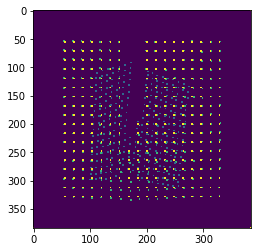

In [14]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 8.4) Supervised Euclidean for LASTEN2_50
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
tf.keras.backend.clear_session()

store_path = 'experiments/8_4_euclidean'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/test'

#path_fixed = r'D:\Julian\data\LASTEN2_50\fix'
#path_train = r'D:\Julian\data\LASTEN2_50\train'
#path_validation = r'D:\Julian\data\LASTEN2_50\validation'
#path_test = r'D:\Julian\data\LASTEN2_50\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/100


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


84/84 [==============================] - 49s 578ms/step - loss: 1046.4774 - val_loss: 10918.7080
Epoch 2/100
84/84 [==============================] - 50s 591ms/step - loss: 428.3996 - val_loss: 1292.9630
Epoch 3/100
84/84 [==============================] - 49s 586ms/step - loss: 226.9274 - val_loss: 558.1604
Epoch 4/100
84/84 [==============================] - 49s 589ms/step - loss: 172.9062 - val_loss: 533.1637
Epoch 5/100
84/84 [==============================] - 50s 590ms/step - loss: 115.3071 - val_loss: 142.5794
Epoch 6/100
84/84 [==============================] - 50s 593ms/step - loss: 71.1081 - val_loss: 187.4314
Epoch 7/100
84/84 [==============================] - 50s 590ms/step - loss: 61.1909 - val_loss: 81.9022
Epoch 8/100
84/84 [==============================] - 49s 585ms/step - loss: 63.9441 - val_loss: 549.8427
Epoch 9/100
84/84 [==============================] - 49s 583ms/step - loss: 42.1091 - val_loss: 292.5929
Epoch 10/100


84/84 [==============================] - 48s 577ms/step - loss: 36.2976 - val_loss: 68.5427
Epoch 11/100
84/84 [==============================] - 49s 584ms/step - loss: 27.5079 - val_loss: 73.2423
Epoch 12/100
84/84 [==============================] - 49s 585ms/step - loss: 20.1257 - val_loss: 41.0911
Epoch 13/100
84/84 [==============================] - 49s 585ms/step - loss: 21.3459 - val_loss: 49.8178
Epoch 14/100
84/84 [==============================] - 49s 586ms/step - loss: 26.5006 - val_loss: 97.6189
Epoch 15/100
84/84 [==============================] - 49s 588ms/step - loss: 28.7615 - val_loss: 150.9309
Epoch 16/100
84/84 [==============================] - 49s 588ms/step - loss: 19.5791 - val_loss: 46.3205
Epoch 17/100
84/84 [==============================] - 49s 586ms/step - loss: 23.0117 - val_loss: 52.6739
Epoch 18/100
84/84 [==============================] - 49s 585ms/step - loss: 14.7899 - val_loss: 28.4646
Epoch 19/100
83/84 [============================>.] - ETA: 0s - los

84/84 [==============================] - 49s 584ms/step - loss: 13.2682 - val_loss: 39.5263
Epoch 20/100
84/84 [==============================] - 48s 577ms/step - loss: 10.7144 - val_loss: 13.1486
Epoch 21/100
84/84 [==============================] - 48s 577ms/step - loss: 11.4971 - val_loss: 40.5738
Epoch 22/100
84/84 [==============================] - 50s 591ms/step - loss: 10.2074 - val_loss: 31.0800
Epoch 23/100
84/84 [==============================] - 49s 589ms/step - loss: 12.5885 - val_loss: 74.2810
Epoch 24/100
84/84 [==============================] - 49s 586ms/step - loss: 9.0878 - val_loss: 36.9538
Epoch 25/100
84/84 [==============================] - 49s 586ms/step - loss: 13.0834 - val_loss: 37.5623
Epoch 26/100
84/84 [==============================] - 49s 587ms/step - loss: 19.4297 - val_loss: 41.7157
Epoch 27/100
84/84 [==============================] - 49s 586ms/step - loss: 20.8478 - val_loss: 66.5690
Epoch 28/100
84/84 [==============================] - ETA: 0s - loss:

84/84 [==============================] - 49s 584ms/step - loss: 15.7702 - val_loss: 38.6453
Epoch 29/100
84/84 [==============================] - 48s 576ms/step - loss: 8.3393 - val_loss: 20.0201
Epoch 30/100
84/84 [==============================] - 50s 591ms/step - loss: 8.4133 - val_loss: 20.5762
Epoch 31/100
84/84 [==============================] - 49s 585ms/step - loss: 14.5989 - val_loss: 53.7516
Epoch 32/100
84/84 [==============================] - 49s 586ms/step - loss: 9.1826 - val_loss: 38.6052
Epoch 33/100
84/84 [==============================] - 49s 587ms/step - loss: 17.1409 - val_loss: 89.8921
Epoch 34/100
84/84 [==============================] - 50s 590ms/step - loss: 18.0956 - val_loss: 60.9558
Epoch 35/100
84/84 [==============================] - 49s 588ms/step - loss: 33.5692 - val_loss: 190.6672
Epoch 36/100
84/84 [==============================] - 49s 587ms/step - loss: 10.5544 - val_loss: 35.7161
Epoch 37/100
84/84 [==============================] - ETA: 0s - loss: 

84/84 [==============================] - 49s 586ms/step - loss: 8.9945 - val_loss: 8.4788
Epoch 38/100
84/84 [==============================] - 48s 573ms/step - loss: 11.8898 - val_loss: 16.6845
Epoch 39/100
84/84 [==============================] - 48s 570ms/step - loss: 8.4527 - val_loss: 38.7140
Epoch 40/100
84/84 [==============================] - 48s 577ms/step - loss: 7.7133 - val_loss: 9.9340
Epoch 41/100
84/84 [==============================] - 48s 570ms/step - loss: 5.9171 - val_loss: 9.8127
Epoch 42/100
84/84 [==============================] - 48s 570ms/step - loss: 6.6881 - val_loss: 7.6311
Epoch 43/100
84/84 [==============================] - 48s 570ms/step - loss: 5.1117 - val_loss: 7.7331
Epoch 44/100
84/84 [==============================] - 48s 573ms/step - loss: 11.3606 - val_loss: 75.4807
Epoch 45/100
84/84 [==============================] - 48s 570ms/step - loss: 16.1987 - val_loss: 23.5513
Epoch 46/100
84/84 [==============================] - 48s 572ms/step - loss: 8.

84/84 [==============================] - 48s 577ms/step - loss: 4.7673 - val_loss: 16.3364
Epoch 48/100
84/84 [==============================] - 48s 575ms/step - loss: 4.1321 - val_loss: 10.0123
Epoch 49/100
84/84 [==============================] - 48s 573ms/step - loss: 4.0516 - val_loss: 12.6483
Epoch 50/100
84/84 [==============================] - 49s 580ms/step - loss: 5.6498 - val_loss: 9.0949
Epoch 51/100
84/84 [==============================] - 49s 581ms/step - loss: 4.3071 - val_loss: 12.2619
Epoch 52/100
84/84 [==============================] - 48s 576ms/step - loss: 6.1040 - val_loss: 13.0019
Epoch 53/100
84/84 [==============================] - 48s 577ms/step - loss: 6.6657 - val_loss: 19.7449
Epoch 54/100
84/84 [==============================] - 48s 577ms/step - loss: 9.9247 - val_loss: 20.7220
Epoch 55/100
84/84 [==============================] - 48s 577ms/step - loss: 11.2507 - val_loss: 392.0812
Epoch 56/100
83/84 [============================>.] - ETA: 0s - loss: 31.679

84/84 [==============================] - 48s 576ms/step - loss: 31.5776 - val_loss: 48.2366
Epoch 57/100
84/84 [==============================] - 48s 573ms/step - loss: 18.5834 - val_loss: 190.9550
Epoch 58/100
84/84 [==============================] - 50s 598ms/step - loss: 11.7070 - val_loss: 26.9070
Epoch 59/100
84/84 [==============================] - 49s 585ms/step - loss: 8.3464 - val_loss: 7.8967
Epoch 60/100
84/84 [==============================] - 48s 573ms/step - loss: 5.1948 - val_loss: 18.0528
Epoch 61/100
84/84 [==============================] - 50s 598ms/step - loss: 5.5819 - val_loss: 11.6467
Epoch 62/100
84/84 [==============================] - 48s 567ms/step - loss: 4.4324 - val_loss: 10.5508
Epoch 63/100
84/84 [==============================] - 48s 568ms/step - loss: 6.9121 - val_loss: 18.8459
Epoch 64/100
84/84 [==============================] - 48s 568ms/step - loss: 4.0463 - val_loss: 8.8337
Epoch 65/100
84/84 [==============================] - ETA: 0s - loss: 4.735

84/84 [==============================] - 48s 569ms/step - loss: 4.7359 - val_loss: 19.6941
Epoch 66/100
84/84 [==============================] - 48s 576ms/step - loss: 7.5874 - val_loss: 9.9303
Epoch 67/100
84/84 [==============================] - 51s 608ms/step - loss: 9.7565 - val_loss: 24.3501
Epoch 68/100
84/84 [==============================] - 51s 608ms/step - loss: 4.6561 - val_loss: 11.6257
Epoch 69/100
84/84 [==============================] - 52s 615ms/step - loss: 4.7264 - val_loss: 24.2337
Epoch 70/100
84/84 [==============================] - 50s 596ms/step - loss: 7.0695 - val_loss: 12.7389
Epoch 71/100
84/84 [==============================] - 48s 573ms/step - loss: 4.7347 - val_loss: 7.0573
Epoch 72/100
84/84 [==============================] - 49s 585ms/step - loss: 3.3783 - val_loss: 8.9241
Epoch 73/100
84/84 [==============================] - 48s 569ms/step - loss: 3.4067 - val_loss: 9.0278
Epoch 74/100
84/84 [==============================] - ETA: 0s - loss: 5.0670WARNI

84/84 [==============================] - 48s 570ms/step - loss: 5.0670 - val_loss: 13.8877
Epoch 75/100
84/84 [==============================] - 48s 568ms/step - loss: 4.6921 - val_loss: 10.5714
Epoch 76/100
84/84 [==============================] - 48s 567ms/step - loss: 3.4525 - val_loss: 15.0702
Epoch 77/100
84/84 [==============================] - 48s 569ms/step - loss: 5.2946 - val_loss: 19.1898
Epoch 78/100
84/84 [==============================] - 48s 568ms/step - loss: 5.6757 - val_loss: 18.7602
Epoch 79/100
84/84 [==============================] - 48s 568ms/step - loss: 5.5216 - val_loss: 9.6630
Epoch 80/100
84/84 [==============================] - 48s 574ms/step - loss: 4.4578 - val_loss: 18.9405
Epoch 81/100
84/84 [==============================] - 48s 570ms/step - loss: 3.5567 - val_loss: 10.7951
Epoch 82/100
84/84 [==============================] - 48s 570ms/step - loss: 7.0447 - val_loss: 8.2422
Epoch 83/100
84/84 [==============================] - 48s 569ms/step - loss: 6.

84/84 [==============================] - 48s 569ms/step - loss: 6.7598 - val_loss: 24.3185
Epoch 85/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7294 - val_loss: 13.8400
Epoch 86/100
84/84 [==============================] - 48s 568ms/step - loss: 3.7822 - val_loss: 16.9950
Epoch 87/100
84/84 [==============================] - 48s 570ms/step - loss: 4.9949 - val_loss: 17.5308
Epoch 88/100
84/84 [==============================] - 48s 568ms/step - loss: 7.7823 - val_loss: 19.4007
Epoch 89/100
84/84 [==============================] - 48s 569ms/step - loss: 4.7100 - val_loss: 7.9975
Epoch 90/100
84/84 [==============================] - 48s 574ms/step - loss: 7.8637 - val_loss: 17.8354
Epoch 91/100
84/84 [==============================] - 49s 585ms/step - loss: 5.8352 - val_loss: 14.5949
Epoch 92/100
84/84 [==============================] - 48s 569ms/step - loss: 7.3806 - val_loss: 29.1353
Epoch 93/100
83/84 [============================>.] - ETA: 0s - loss: 10.3454W

84/84 [==============================] - 48s 570ms/step - loss: 10.3004 - val_loss: 15.1737
Epoch 94/100
84/84 [==============================] - 48s 569ms/step - loss: 4.4161 - val_loss: 8.6925
Epoch 95/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7366 - val_loss: 6.8038
Epoch 96/100
84/84 [==============================] - 48s 570ms/step - loss: 2.7644 - val_loss: 9.7750
Epoch 97/100
84/84 [==============================] - 48s 568ms/step - loss: 2.8873 - val_loss: 6.5769
Epoch 98/100
84/84 [==============================] - 48s 569ms/step - loss: 2.8804 - val_loss: 5.3810
Epoch 99/100
84/84 [==============================] - 48s 568ms/step - loss: 2.0448 - val_loss: 4.6946
Epoch 100/100
84/84 [==============================] - 48s 575ms/step - loss: 2.2166 - val_loss: 9.9280


# Evaluation
Evaluate the trained network

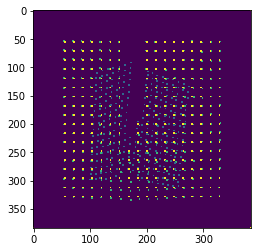

In [14]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)